# Analysis of Xenium melanoma spatial data using scanpy and squiqpy

## Introduction 

In the rapidly evolving field of genomics, understanding the spatial organization of gene expression within tissues is pivotal for unraveling complex biological processes and disease mechanisms. Traditional single-cell RNA sequencing (scRNA-seq) has provided invaluable insights into cellular diversity, but it often lacks the spatial context necessary to fully comprehend cellular interactions and tissue architecture. Enter spatial transcriptomics—a revolutionary approach that maps gene expression directly within the spatial framework of tissues.

Xenium, developed by 10x Genomics, stands at the forefront of spatial gene expression technologies. Leveraging advanced in situ hybridization techniques, Xenium enables high-resolution, multiplexed profiling of RNA molecules within intact tissue samples. This powerful platform generates rich datasets that capture not only the gene expression profiles of individual cells but also their precise spatial locations and interactions within the tissue microenvironment.

Squipy emerges as a versatile Python library tailored for the analysis of spatial genomics data, including that produced by Xenium. Designed with flexibility and scalability in mind, Squipy offers a comprehensive suite of functionalities for data preprocessing, visualization, spatial clustering, and downstream analyses. Its intuitive interface and compatibility with popular data formats make it an indispensable tool for researchers aiming to decode the spatial dimensions of gene expression.

This tutorial is crafted to guide you through the end-to-end analysis of Xenium data using Squipy. We will begin with data import and preprocessing, delve into quality control and normalization, explore spatial visualization and clustering techniques, and conclude with advanced analyses such as spatially informed differential expression and interaction mapping.

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq
import spatialdata as sd
from spatialdata_io import xenium

There are a number of curated, high quality spatial datasets that are publicly available on the [10X Genomics](https://www.10xgenomics.com/datasets?configure%5BhitsPerPage%5D=50&configure%5BmaxValuesPerFacet%5D=1000&page=2) website. For this demo, we will download the [FFPE Human Skin Primary Dermal Melanoma with 5K Human Pan Tissue and Pathways Panel](https://www.10xgenomics.com/datasets/xenium-prime-ffpe-human-skin) data. If you have no already downloaded this data, you should go to the "Output and supplemental files" tab and download the "Xenium Output Bundle (full)" file, as well as the supplementary files, Post-Xenium H&E Image (OME-TIFF) and H&E Image Alignment File (CSV).

Below, we load AnnData (h5) file from this Xenium dataset that we have downloaded:

In [63]:
### https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5
#adata = sc.read_10x_h5(filename="../xdd201/Downloads/Xenium_FFPE_Human_Breast_Cancer_Rep1_outs/cell_feature_matrix.h5")
adata = sc.read_10x_h5(filename="/home/thelonius/tmp/spatial_workflows/data/xenium_demo_data/Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_outs/cell_feature_matrix.h5")

This displays the size of the matrix of the AnnData object, which can be interpreted as 382 genes in 87499 spatial cells

In [64]:
adata

AnnData object with n_obs × n_vars = 87499 × 382
    var: 'gene_ids', 'feature_types', 'genome'

Load the cell index

In [65]:
### https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz
#df = pd.read_csv("../xdd201/Downloads/Xenium_FFPE_Human_Breast_Cancer_Rep1_outs/cells.csv")
df = pd.read_csv("/home/thelonius/tmp/spatial_workflows/data/xenium_demo_data/Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_outs/cells.csv.gz")

In [66]:
df.set_index(adata.obs_names, inplace=True)
adata.obs = df.copy()

In [67]:
adata.obs

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area
aaaahdpa-1,aaaahdpa-1,839.648499,708.609436,319,0,0,0,0,319,222.575164,33.009220
aaaakeom-1,aaaakeom-1,836.833252,630.847229,131,0,0,0,0,131,108.104066,23.390938
aaaamacd-1,aaaamacd-1,847.556458,634.055603,83,0,0,0,0,83,64.392815,14.088751
aaabcmaf-1,aaabcmaf-1,828.426575,636.969177,117,0,0,0,0,117,88.054691,6.818594
aaabgold-1,aaabgold-1,837.756653,639.850037,145,0,0,0,0,145,94.782972,21.945938
...,...,...,...,...,...,...,...,...,...,...,...
oimimkme-1,oimimkme-1,5896.068848,1814.893433,217,0,0,0,0,217,79.158909,29.712814
oimjcdbg-1,oimjcdbg-1,5897.338379,1806.026611,184,0,0,0,0,184,61.412502,26.235782
oimjcodj-1,oimjcodj-1,5901.827637,1746.910278,131,0,0,0,0,131,414.805328,14.766094
oimjcofe-1,oimjcofe-1,5901.106934,1763.095947,208,0,0,0,0,208,302.998448,20.320313


In [68]:
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [69]:
adata.obsm["spatial"]

array([[ 839.64849854,  708.60943604],
       [ 836.83325195,  630.847229  ],
       [ 847.55645752,  634.05560303],
       ...,
       [5901.82763672, 1746.91027832],
       [5901.10693359, 1763.09594727],
       [5895.57080078, 1781.12072754]])

Take a look at the head of the genes in the Xenium panel

In [70]:
print(adata.var['gene_ids'].head())

ACER1     ENSG00000167769
ACHE      ENSG00000087085
ACTA2     ENSG00000107796
ADAM12    ENSG00000148848
AHNAK2    ENSG00000185567
Name: gene_ids, dtype: object


In [71]:
gene_names_list = adata.var.index.tolist()
print(gene_names_list)

['ACER1', 'ACHE', 'ACTA2', 'ADAM12', 'AHNAK2', 'AHSP', 'AIF1', 'AIM2', 'AKAP5', 'AKR1C1', 'ALAS2', 'ALOX5AP', 'APCDD1', 'APOD', 'AQP1', 'AQP3', 'AREG', 'ARG1', 'ARHGDIB', 'ASPN', 'ATF3', 'AXL', 'AZGP1', 'BASP1', 'BCAN', 'BCL2A1', 'BHLHE41', 'BIRC3', 'BIRC5', 'C11orf96', 'C15orf48', 'C1QA', 'C1orf54', 'C3', 'C3AR1', 'C5AR1', 'CA1', 'CALCRL', 'CALD1', 'CAPNS2', 'CBFA2T3', 'CCL19', 'CCL2', 'CCL22', 'CCL3', 'CCL4', 'CCL5', 'CCL8', 'CCND1', 'CCND3', 'CCR2', 'CCR7', 'CD14', 'CD163', 'CD1A', 'CD1B', 'CD1C', 'CD207', 'CD27', 'CD274', 'CD276', 'CD34', 'CD3D', 'CD3E', 'CD3G', 'CD4', 'CD40LG', 'CD52', 'CD63', 'CD68', 'CD69', 'CD79A', 'CD83', 'CD8A', 'CD93', 'CDC20', 'CDH2', 'CDH5', 'CDK1', 'CENPF', 'CES1', 'CLDN1', 'CLDN4', 'CLDN5', 'CLEC10A', 'CLEC9A', 'COCH', 'COL17A1', 'COL5A2', 'COL6A1', 'COL6A2', 'COL6A3', 'COMP', 'COTL1', 'CPE', 'CPVL', 'CR2', 'CRABP2', 'CRYAB', 'CSF1R', 'CSPG4', 'CST7', 'CTLA4', 'CTNNB1', 'CTSL', 'CTSW', 'CTSZ', 'CXADR', 'CXCL1', 'CXCL10', 'CXCL11', 'CXCL12', 'CXCL13', 'CX

It looks like out of all the genes in this Xenium panel, the following genes are likely to be highly expressed in melanoma, but not as highly expressed in healthy tissue. We will visualize some of the following genes later in this workflow:  MITF, MLANA, PMEL, TYR, TYRP1, DCT, MIA, and S100B

## Calculate quality control metrics
Calculate the quality control metrics on the anndata.AnnData using scanpy.pp.calculate_qc_metrics.

In [72]:
### Calculate quality control metrics
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

The percentage of control probes and control codewords can be calculated from adata.obs

In [73]:
### calculate and print the percentage of control probes
cprobes = (adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100)
print(f"Negative DNA probe count % : {cprobes}")

Negative DNA probe count % : 0.0012551331253257809


In [74]:
### calculate and print the percentage of control codewords 
cwords = (adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100)
print(f"Negative decoding count % : {cwords}")

Negative decoding count % : 0.003366710030285624


Next we plot the distribution of total transcripts per cell, unique transcripts per cell, area of segmented cells and the ratio of nuclei area to their cells

<Axes: title={'center': 'Nucleus ratio'}, ylabel='Count'>

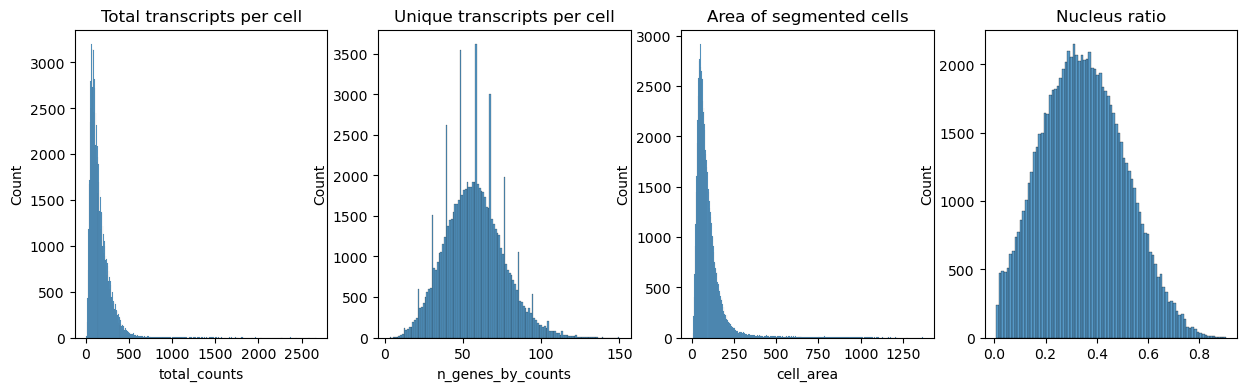

In [75]:
### plot the distribution of: 
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])

axs[1].set_title("Unique transcripts per cell")
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, ax=axs[1])

axs[2].set_title("Area of segmented cells")
sns.histplot(adata.obs["cell_area"], kde=False, ax=axs[2])

axs[3].set_title("Nucleus ratio")
sns.histplot(adata.obs["nucleus_area"] / adata.obs["cell_area"], kde=False, ax=axs[3])

Filter the cells based on the minimum number of counts required using scanpy.pp.filter_cells. Filter the genes based on the minimum number of cells required with scanpy.pp.filter_genes. The parameters for the both were specified based on the plots above. They were set to filter out the cells and genes with minimum counts and minimum cells respectively.

Other filter criteria might be cell area, DAPI signal or a minimum of unique transcripts.

In [76]:
## Filter the cells and genes
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)

Observe the size of the adata object after filtering

In [77]:
adata # 167780 × 313

AnnData object with n_obs × n_vars = 87477 × 382
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'spatial'

Normalize counts per cell using scanpy.pp.normalize_total.

Logarithmize, do principal component analysis, compute a neighborhood graph of the observations using scanpy.pp.log1p, scanpy.pp.pca and scanpy.pp.neighbors respectively.

Use scanpy.tl.umap to embed the neighborhood graph of the data and cluster the cells into subgroups employing scanpy.tl.leiden.

In [78]:
## standard scanpy workflow
sc.pp.normalize_total(adata, inplace=True) # Normalize counts per cell
sc.pp.log1p(adata) # Logarithmize

# sc.pp.highly_variable_genes (adata) # 313 genes

sc.pp.pca(adata) # do principal component analysis
sc.pp.neighbors(adata) # compute a neighborhood graph
sc.tl.umap(adata) # embed the neighborhood graph of the data
sc.tl.leiden(adata, resolution=0.3) # cluster the cells into subgroups

## Visualize annotation on UMAP and spatial coordinates

Subplot with scatter plot in UMAP (Uniform Manifold Approximation and Projection) basis. The embedded points were colored, respectively, according to the total counts, number of genes by counts, and leiden clusters in each of the subplots. This gives us some idea of what the data looks like.

### Visualize cell clusters on UMAP

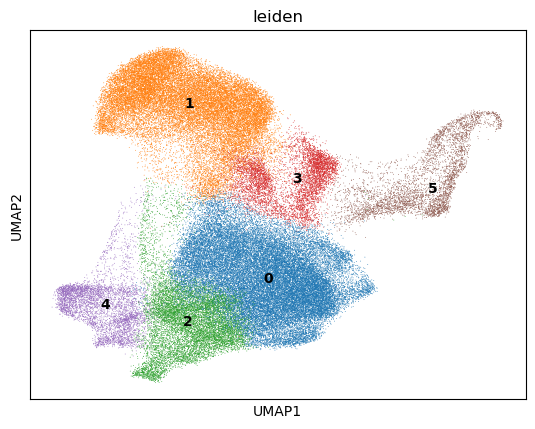

In [79]:
sc.pl.umap(adata, color="leiden", legend_loc='on data', wspace=0.4)

### Visualize gene expression on UMAP

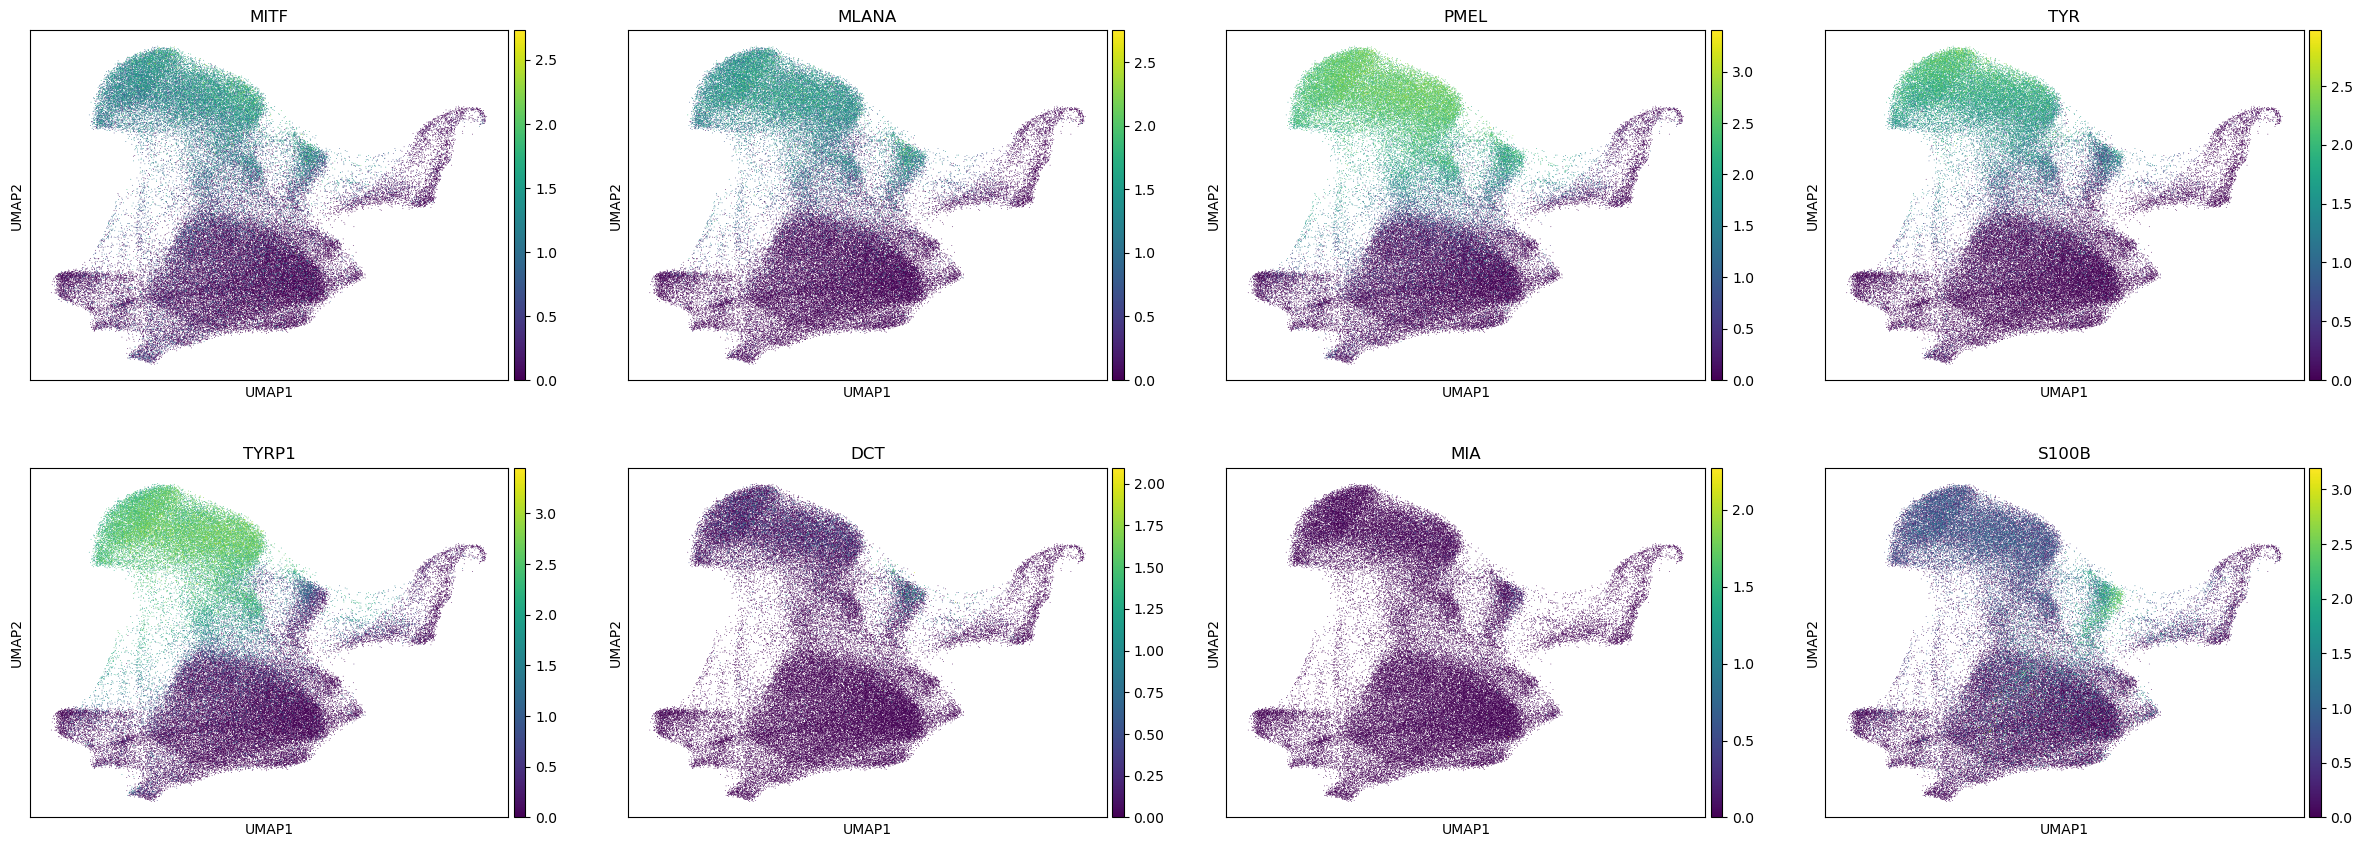

In [80]:
# sc.pl.umap(adata, color=['ACER1', 'ACTA2'], use_raw=False)
sc.pl.umap(adata, color=['MITF', 'MLANA', 'PMEL', 'TYR', 'TYRP1', 'DCT', 'MIA', 'S100B'], use_raw=False)

### Visualize cell clusters on spatial coordinates

/home/thelonius/anaconda3/envs/spatial_data2/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


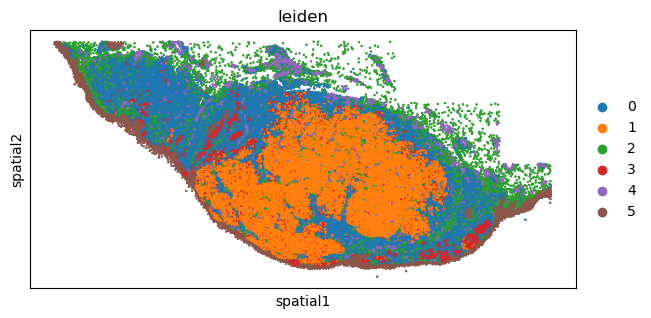

In [81]:
sq.pl.spatial_scatter(adata, library_id="spatial", shape=None, color=['leiden'], wspace=0.4)

## Computation of spatial statistics

This example shows how to compute centrality scores, given a spatial graph and cell type annotation.

The scores calculated are closeness centrality, degree centrality and clustering coefficient with the following properties:

    closeness centrality - measure of how close the group is to other nodes.

    clustering coefficient - measure of the degree to which nodes cluster together.

    degree centrality - fraction of non-group members connected to group members.

All scores are descriptive statistics of the spatial graph.

This dataset contains Leiden cluster groups’ annotations in adata.obs, which are used for calculation of centrality scores.

### Building a spatial neighborhood graph

First, we need to compute a connectivity matrix from spatial coordinates to calculate the centrality scores. We can use squidpy.gr.spatial_neighbors for this purpose. We use the coord_type="generic" based on the data and the neighbors are classified with Delaunay triangulation by specifying delaunay=True.

In [82]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)

### Compute centrality scores

Centrality scores are calculated with squidpy.gr.centrality_scores, with the Leiden groups as clusters.

In [83]:
sq.gr.centrality_scores(adata, cluster_key="leiden")

The results were visualized by plotting the average centrality, closeness centrality, and degree centrality using squidpy.pl.centrality_scores.

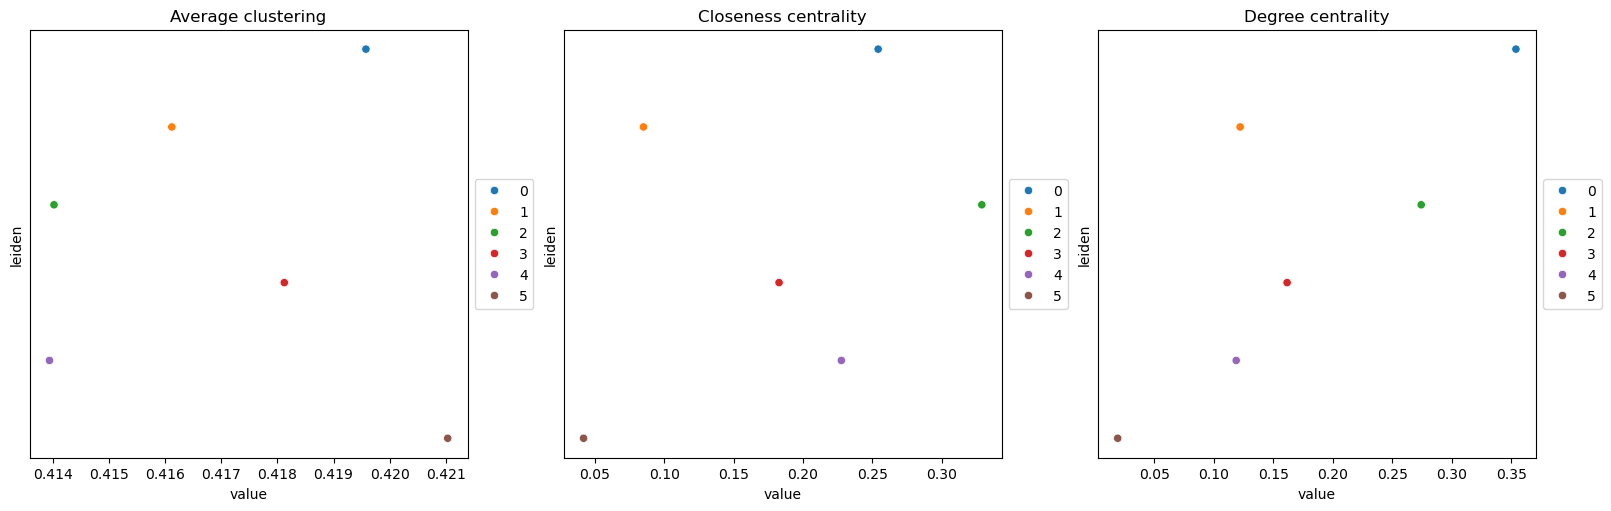

In [84]:
sq.pl.centrality_scores(adata, cluster_key="leiden", figsize=(16, 5))

### Compute co-occurrence probability

This example shows how to compute the co-occurrence probability.

If you want this portion of the workflow to run faster for a demo, it is possible to create a subset of the original Anndata object and work with that (as shown below). You can also work with sdata.tables["subsample"] directly, but to keep verbosity low, we just use the anndata.Anndata object as before.

In [85]:
## how to subsample an AnnData object
'''
adata_subsample =  sc.pp.subsample(adata, fraction=0.5, copy=True)
sq.gr.co_occurrence(adata_subsample, cluster_key="leiden")
'''

'\nadata_subsample =  sc.pp.subsample(adata, fraction=0.5, copy=True)\nsq.gr.co_occurrence(adata_subsample, cluster_key="leiden")\n'

In [86]:
sq.gr.co_occurrence(adata, cluster_key="leiden")

  0%|          | 0/946 [00:00<?, ?/s]

This plot displays the conditional probability of observing one cluster inn the presence of another cluster, where the probability is calculated by observing in the radius size of interest. The score is computed across increasing radii size around each cell in the tissue.

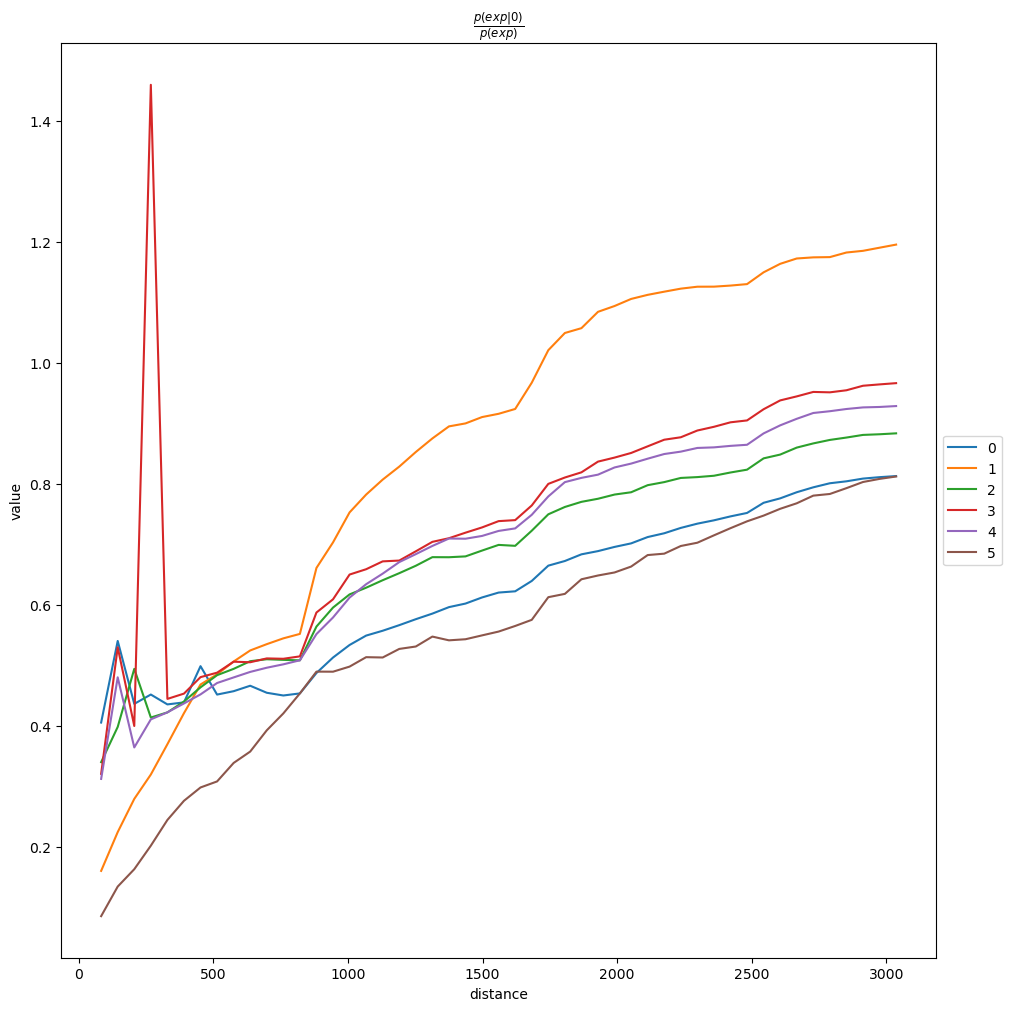

In [87]:
sq.pl.co_occurrence(adata, cluster_key="leiden", clusters="0", figsize=(10, 10))

### Neighbors enrichment analysis

This example shows how to run the neighbors enrichment analysis routine.

It calculates an enrichment score based on proximity on the connectivity graph of cell clusters. The number of observed events is compared against permutations and a z-score is computed.

This dataset contains cell type annotations in adata.obs which are used for calculation of the neighborhood enrichment. We calculate the neighborhood enrichment score with squidpy.gr.nhood_enrichment.

In [88]:
sq.gr.nhood_enrichment(adata, cluster_key="leiden")

  0%|          | 0/1000 [00:00<?, ?/s]

And visualize the results with squidpy.pl.nhood_enrichment.

/home/thelonius/anaconda3/envs/spatial_data2/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


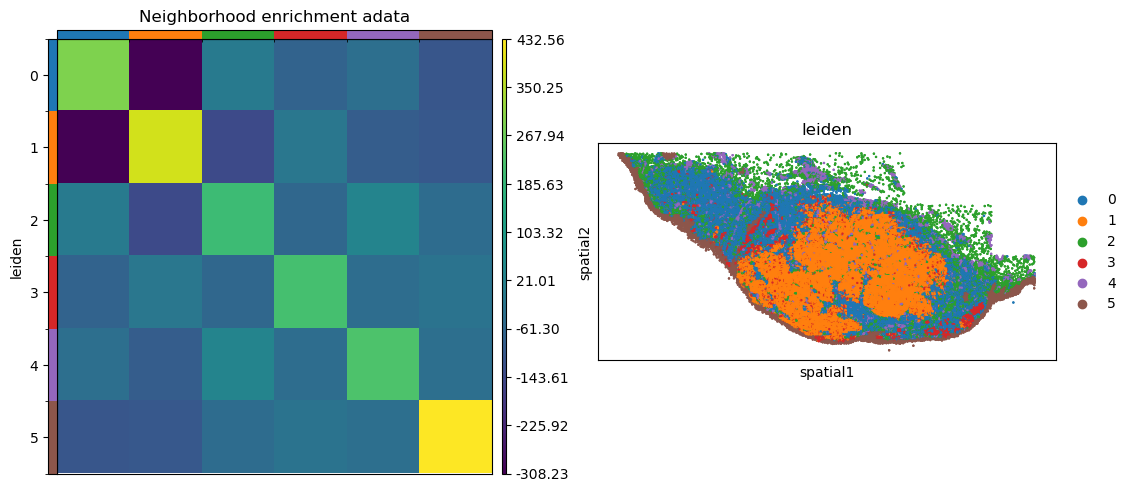

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
sq.pl.nhood_enrichment(adata, cluster_key="leiden", figsize=(8, 8), title="Neighborhood enrichment adata", ax=ax[0])
sq.pl.spatial_scatter(adata, color="leiden", shape=None, size=2, ax=ax[1])

### Compute Moran’s I score

This example shows how to compute the Moran’s I global spatial auto-correlation statistics.

The Moran’s I global spatial auto-correlation statistics evaluates whether features (i.e. genes) shows a pattern that is clustered, dispersed or random in the tissue are under consideration.

We can compute the Moran’s I score with squidpy.gr.spatial_autocorr and mode = ‘moran’. We first need to compute a spatial graph with squidpy.gr.spatial_neighbors. We will also subset the number of genes to evaluate.

In [91]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(adata, mode="moran", n_perms=100, n_jobs=1)
adata.uns["moranI"].head(10)

  0%|          | 0/100 [00:00<?, ?/s]

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
TYRP1,0.907842,0.0,0.000004,0.0,0.009901,0.000009,0.0,0.0,0.01014
PMEL,0.880539,0.0,0.000004,0.0,0.009901,0.000008,0.0,0.0,0.01014
KRT16,0.800701,0.0,0.000004,0.0,0.009901,0.000009,0.0,0.0,0.01014
TYR,0.800029,0.0,0.000004,0.0,0.009901,0.000009,0.0,0.0,0.01014
DSP,0.784162,0.0,0.000004,0.0,0.009901,0.000010,0.0,0.0,0.01014
KRT5,0.782448,0.0,0.000004,0.0,0.009901,0.000010,0.0,0.0,0.01014
QPCT,0.781530,0.0,0.000004,0.0,0.009901,0.000007,0.0,0.0,0.01014
DMKN,0.769896,0.0,0.000004,0.0,0.009901,0.000007,0.0,0.0,0.01014
KRTDAP,0.754670,0.0,0.000004,0.0,0.009901,0.000009,0.0,0.0,0.01014
KRT17,0.753100,0.0,0.000004,0.0,0.009901,0.000009,0.0,0.0,0.01014


We can visualize some of those genes with squidpy.pl.spatial_scatter. We could also pass mode = 'geary' to compute a closely related auto-correlation statistic, Geary’s C. See squidpy.gr.spatial_autocorr for more information.

Let's take a look at some of the genes that have the highest spatial localization:

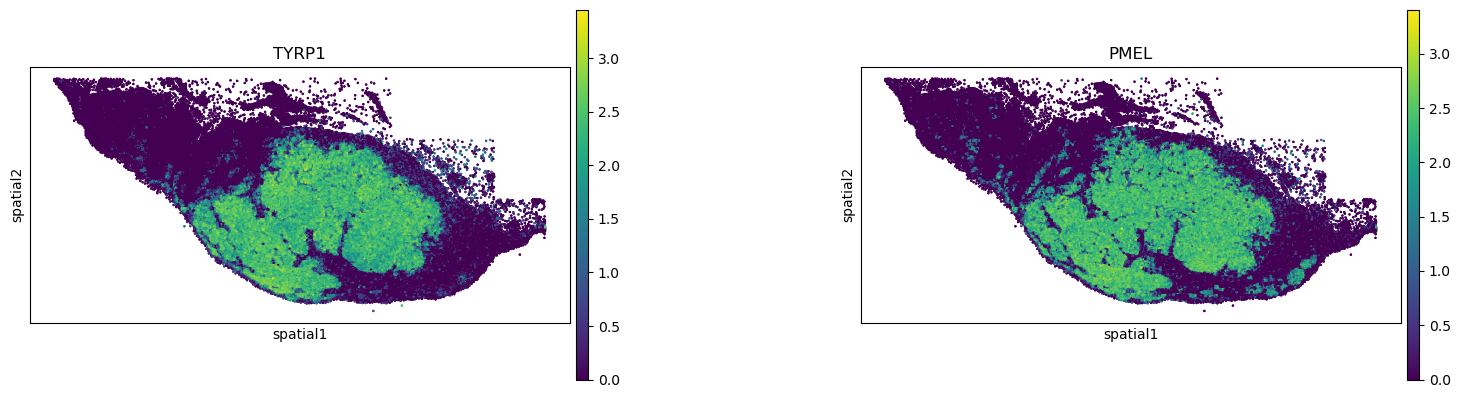

In [92]:
sq.pl.spatial_scatter(adata, library_id="spatial", shape=None, color=['TYRP1', 'PMEL'], wspace=0.4, size=2, img=False)

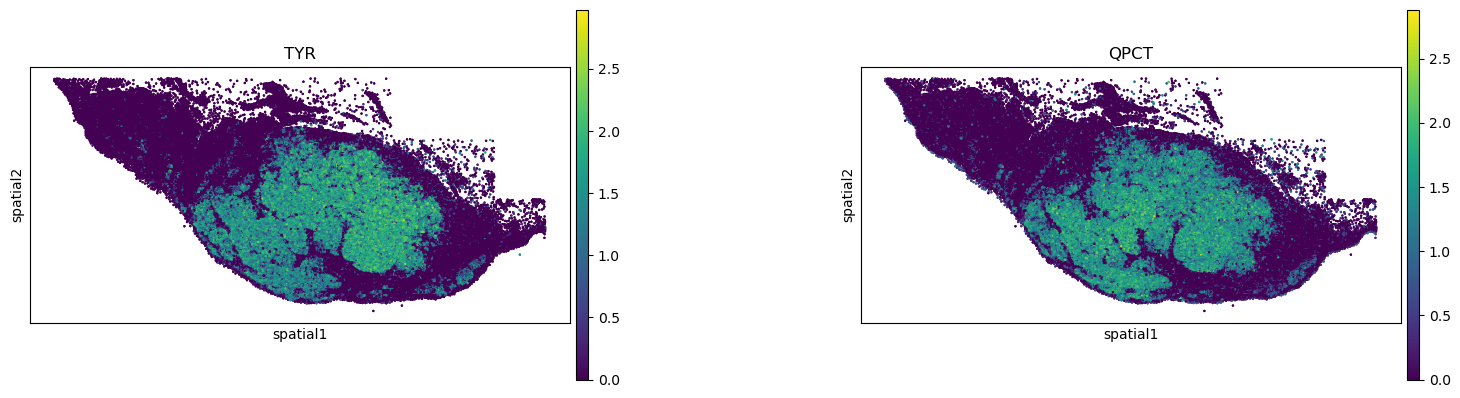

In [93]:
sq.pl.spatial_scatter(adata, library_id="spatial", shape=None, color=['TYR', 'QPCT'], wspace=0.4, size=2, img=False)

## View histology image

Viewing the histology image frequently takes more memory that most local laptops, so it's very important that you have sufficient RAM for the following steps. 

In [94]:
# Load the TIFF image into an ImageContainer.
'''
tiff_path = "./data/xenium_demo_data/Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_outs/morphology_focus.ome.tiff"
# The ImageContainer supports multi-channel images and allows for efficient I/O.
sq.im.ImageContainer(tiff_path)

# Plot the image.
# The plot() method will render the image using matplotlib.
img.plot()

# Optionally, if you need to further customize or ensure the plot stays visible:
#plt.show()



## For plotting we can also use spatialdata-plot, a package for static plotting of spatialdataobjects.
import spatialdata
#import spatialdata_plot # pip install spatialdata

gene_name = ['ACER1', 'ACTA2']
for name in gene_name:
    adata.pl.render_images("morphology_focus").pl.render_shapes(
        "cell_circles",
        color=name,
        table_name="table",
        use_raw=False,
    ).pl.show(
        title=f"{name} expression over Morphology image",
        coordinate_systems="global",
        figsize=(10, 5),
    )
'''

'\ntiff_path = "./data/xenium_demo_data/Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_outs/morphology_focus.ome.tiff"\n# The ImageContainer supports multi-channel images and allows for efficient I/O.\nsq.im.ImageContainer(tiff_path)\n\n# Plot the image.\n# The plot() method will render the image using matplotlib.\nimg.plot()\n\n# Optionally, if you need to further customize or ensure the plot stays visible:\n#plt.show()\n\n\n\n## For plotting we can also use spatialdata-plot, a package for static plotting of spatialdataobjects.\nimport spatialdata\n#import spatialdata_plot # pip install spatialdata\n\ngene_name = [\'ACER1\', \'ACTA2\']\nfor name in gene_name:\n    adata.pl.render_images("morphology_focus").pl.render_shapes(\n        "cell_circles",\n        color=name,\n        table_name="table",\n        use_raw=False,\n    ).pl.show(\n        title=f"{name} expression over Morphology image",\n        coordinate_systems="global",\n        figsize=(10, 5),\n    )\n'

### Interactive analysis and visualization with napari-spatialdata

Additionally, one can use napari-spatialdata to visualize Xenium data with an interactive GUI. (TODO)

In [95]:
'''
from napari_spatialdata import Interactive

Interactive(sdata)
'''

'\nfrom napari_spatialdata import Interactive\n\nInteractive(sdata)\n'

## References

https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_xenium.html

https://github.com/quentinblampey/spatialdata_xenium_explorer/blob/master/docs/10x_tutorials/xenium/xenium_tuto.ipynb

https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks/examples/technology_xenium.html

https://spatialdata.scverse.org/en/latest/tutorials/notebooks/datasets/README.html

https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-libraries-of-mouse-intestine

https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_image_container_zstacks.html

https://spatialdata.scverse.org/projects/napari/en/latest/notebooks/spatialdata.html